# <center>Practice 2:  Hands-on practice with pre-trained neural network architectures </center>

---

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

In [151]:
# Kiểm tra thử máy tính có cuda (gpu) để sử dụng ko
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

# Khởi tạo TensorBoard
writer = SummaryWriter(log_dir='runs/my_exp1')

cpu


---

## Exercises 1: Experiment  with  different  pre-trained  models (VGG, DenseNet, etc.).

In [152]:
from torchvision.models import (
    VGG11_Weights,
    ResNet18_Weights,
    DenseNet121_Weights
)

# Load pre-trained model
models_dict = {
    "vgg11": torchvision.models.vgg11(
        weights=VGG11_Weights.DEFAULT
    ),
    "resnet18": torchvision.models.resnet18(
        weights=ResNet18_Weights.DEFAULT
    ),
    "densenet121": torchvision.models.densenet121(
        weights=DenseNet121_Weights.DEFAULT
    )
}

In [153]:
# Hiển thị cấu trúc của các mô hình
# print(f"Cấu trúc của VGG11\n{models_dict['vgg11']}\n")
# print('==='*60)
# print(f"\nCấu trúc của RESNET18\n{models_dict['resnet18']}\n")
# print('==='*60)
# print(f"\nCấu trúc của densenet121\n{models_dict['densenet121']}\n")

---

---

## Exercises 2: Adjust  the  hyperparameters  (learning  rate,  batch size, etc.).

### 2.1. Load dataset from torchvision.datasets

In [154]:
# Transform dữ liệu ảnh đầu vào
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Biến đổi về dạng tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load tập train
full_train_dataset = datasets.CIFAR10(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

# Load tập test
test_dataset = datasets.CIFAR10(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

In [155]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

In [156]:
# Hiển thị thông tin của dataset
print(f'train size: {len(train_dataset)} - val size: {len(val_dataset)} - test size: {len(test_dataset)}')
print(f'Class: {len(full_train_dataset.classes)}\n{full_train_dataset.classes}')

lst_class = full_train_dataset.classes   # danh sánh labels
nums_class = len(full_train_dataset.classes) # số lượng classes

train size: 40000 - val size: 10000 - test size: 10000
Class: 10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


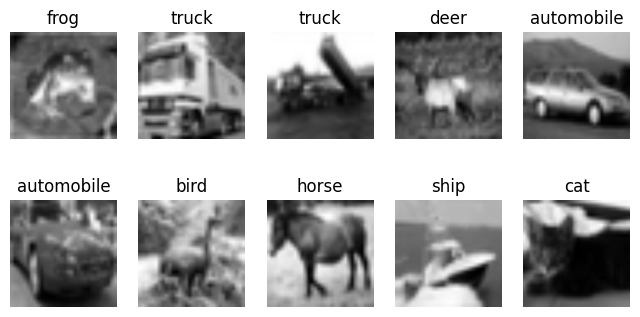

In [157]:
# Hiển thị ảnh từ tập train
fig, axes = plt.subplots(2, 5, figsize=(8, 4))

for i, ax in enumerate(axes.flat):
    img, lbl = full_train_dataset[i]

    img = img.mean(dim=0)   # RGB → grayscale [H, W]
    ax.imshow(img, cmap="gray")
    ax.set_title(lst_class[lbl])
    ax.axis("off")

plt.show()

writer.add_figure(tag='train dataset', figure=fig)
writer.close()

---

### 2.2. Sử dụng DataLoader để chia dataset thành các batch

In [159]:
# batch_size=16 (mỗi lần model học từ 16 ảnh), shuffle dữ liệu
use_cuda = torch.cuda.is_available()

train_loader = DataLoader(full_train_dataset, batch_size=16, shuffle=True, pin_memory=use_cuda)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=use_cuda)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, pin_memory=use_cuda)

---

### 2.3. Training model

#### Change the final layer, freeze backbone, unfreeze final layer

In [160]:
for model_name, model in models_dict.items():

    if "vgg11" in model_name:

        # Freeze all backbone
        for param in model.parameters():
            param.requires_grad = False

        # Change final layer
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, nums_class)

        # Unfreeze classifier
        for param in model.classifier.parameters():
            param.requires_grad = True


    elif "resnet18" in model_name:

        # Freeze all backbone
        for param in model.parameters():
            param.requires_grad = False

        # Change final layer
        num_features = model.fc.in_features
        model.fc= nn.Linear(num_features, nums_class)

        # Unfreeze
        for param in model.fc.parameters():
            param.requires_grad = True


    elif "densenet121" in model_name:

        # Freeze all backbone
        for param in model.parameters():
            param.requires_grad = False

        # Change final layer
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, nums_class)

        # Unfreeze classifier
        for param in model.classifier.parameters():
            param.requires_grad = True

In [161]:
criterion = nn.CrossEntropyLoss()   # Khởi tạo hàm loss

# Khởi tạo optimizer
optimizers_dict = {}

for model_name, model in models_dict.items():
    optimizers_dict[model_name] = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001, momentum=0.9
    )

In [162]:
from sklearn.metrics import f1_score, precision_score, recall_score


def evaluate_prf1(model, loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    precision = precision_score(all_labels, all_preds, average="macro")
    recall    = recall_score(all_labels, all_preds, average="macro")
    f1        = f1_score(all_labels, all_preds, average="macro")

    return precision, recall, f1

In [163]:
def train_one_epoch(model, loss_func, optimezer_func, loader, device):

    model.train()
    

    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for images, labels in tqdm(loader):
        optimezer_func.zero_grad()
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimezer_func.step()

        # loss
        running_loss += loss.item()

        # accuracy
        preds = outputs.argmax(dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
    avg_loss = running_loss / len(loader)
    avg_acc = correct_preds / total_samples

    return avg_loss, avg_acc

In [164]:
def val_one_epoch(model, loss_func, loader, device):
    """
    - Chuyển sang eval mode
    - Tắt gradient
    - Không update weight (không backward pass)
    """
    model.eval()

    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():   # Tắt gradient
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_func(outputs, labels)

            # loss
            running_loss += loss.item()

            # accuracy
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / len(loader)
    avg_acc = correct_preds / total_samples

    return avg_loss, avg_acc

In [ ]:
num_epochs = 8
selected_models = {
    "vgg11": models_dict["vgg11"],
    "resnet18": models_dict["resnet18"],
    "densenet121": models_dict["densenet121"]
}

In [ ]:
for model_name, model in selected_models.items():

    model = model.to(device)
    optimizer = optimizers_dict[model_name]

    print(f"\n===== Training {model_name} =====")

    for epoch in range(1, num_epochs+1):

        train_loss, train_acc = train_one_epoch(
            model=model,
            loss_func=criterion,
            optimezer_func=optimizer,
            loader=train_loader,
            device=device
        )

        val_loss, val_acc = val_one_epoch(model=model, loss_func=criterion, loader=val_loader, device=device)

        
        writer.add_scalars(main_tag=f'{model_name}/loss', tag_scalar_dict={'train': train_loss, 'val': val_loss}, global_step=epoch)
        writer.add_scalars(main_tag=f'{model_name}/acc', tag_scalar_dict={'train': train_acc, 'val': val_acc}, global_step=epoch)

        print(f"==> Epoch = {epoch} - loss/train = {train_loss:.4f} - loss/val = {val_loss:.4f}\n")

    precision, recall, f1 = evaluate_prf1(model, test_loader, device)

    
    print(f"* {model_name} Test precision: {precision:.2f} - Test recall: {recall:.2f} - Test f1: {f1:.2f}")

writer.close()


===== Training vgg11 =====


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


==> Epoch = 1 - loss/train = 1.8525 - loss/val = 4.1019



100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


==> Epoch = 2 - loss/train = 0.5118 - loss/val = 5.6724



100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


==> Epoch = 3 - loss/train = 0.0413 - loss/val = 6.6650



100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


==> Epoch = 4 - loss/train = 0.0095 - loss/val = 7.4845



100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


==> Epoch = 5 - loss/train = 0.1215 - loss/val = 7.5542



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]
f:\Document\Tổng hợp các môn học\Deep learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Document\Tổng hợp các môn học\Deep learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


* vgg11 Test precision: 0.00 - Test recall: 0.00 - Test f1: 0.00

===== Training resnet18 =====


100%|██████████| 1/1 [00:00<00:00, 32.64it/s]


==> Epoch = 1 - loss/train = 2.1754 - loss/val = 3.6050



100%|██████████| 1/1 [00:00<00:00, 33.84it/s]


==> Epoch = 2 - loss/train = 1.5468 - loss/val = 5.3246



100%|██████████| 1/1 [00:00<00:00, 33.82it/s]


==> Epoch = 3 - loss/train = 1.9354 - loss/val = 7.4680



100%|██████████| 1/1 [00:00<00:00, 33.24it/s]


==> Epoch = 4 - loss/train = 1.0581 - loss/val = 7.9187



100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


==> Epoch = 5 - loss/train = 1.5338 - loss/val = 8.8877



100%|██████████| 1/1 [00:00<00:00, 29.32it/s]
f:\Document\Tổng hợp các môn học\Deep learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Document\Tổng hợp các môn học\Deep learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


* resnet18 Test precision: 0.00 - Test recall: 0.00 - Test f1: 0.00

===== Training densenet121 =====


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


==> Epoch = 1 - loss/train = 2.0146 - loss/val = 3.3323



100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


==> Epoch = 2 - loss/train = 1.2189 - loss/val = 3.9509



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


==> Epoch = 3 - loss/train = 1.8094 - loss/val = 4.7632



100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


==> Epoch = 4 - loss/train = 1.8812 - loss/val = 5.6934



100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


==> Epoch = 5 - loss/train = 1.6840 - loss/val = 5.5063



100%|██████████| 1/1 [00:00<00:00, 11.01it/s]

* densenet121 Test precision: 0.00 - Test recall: 0.00 - Test f1: 0.00



f:\Document\Tổng hợp các môn học\Deep learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Document\Tổng hợp các môn học\Deep learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


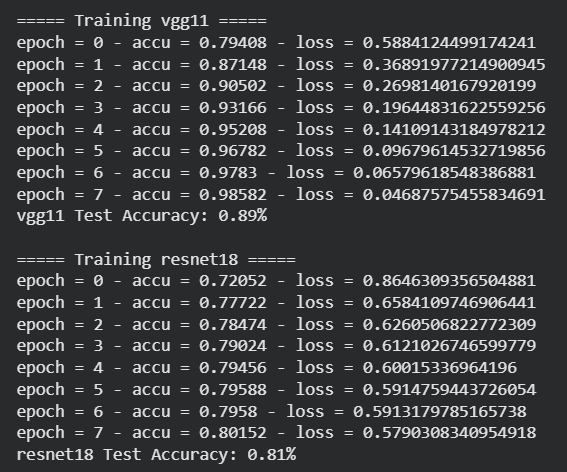

```
===== Training vgg11 =====
epoch = 0 - accu = 0.79408 - loss = 0.5884124499174241
epoch = 1 - accu = 0.87148 - loss = 0.36891977214900945
epoch = 2 - accu = 0.90502 - loss = 0.2698140167920199
epoch = 3 - accu = 0.93166 - loss = 0.19644831622559256
epoch = 4 - accu = 0.95208 - loss = 0.14109143184978212
epoch = 5 - accu = 0.96782 - loss = 0.09679614532719856
epoch = 6 - accu = 0.9783 - loss = 0.06579618548386881
epoch = 7 - accu = 0.98582 - loss = 0.04687575455834691
vgg11 Test Accuracy: 0.89%

===== Training resnet18 =====
epoch = 0 - accu = 0.72052 - loss = 0.8646309356504881
epoch = 1 - accu = 0.77722 - loss = 0.6584109746906441
epoch = 2 - accu = 0.78474 - loss = 0.6260506822772309
epoch = 3 - accu = 0.79024 - loss = 0.6121026746599779
epoch = 4 - accu = 0.79456 - loss = 0.60015336964196
epoch = 5 - accu = 0.79588 - loss = 0.5914759443726054
epoch = 6 - accu = 0.7958 - loss = 0.5913179785165738
epoch = 7 - accu = 0.80152 - loss = 0.5790308340954918
resnet18 Test Accuracy: 0.81%
```
